# Examen de Sistemas Inteligentes junio 2024
## Parte práctica
### Nombre del alumno

Pon aquí tu nombre.

En el laboratorio, se entrega un Jupiter Notebook con las respuestas. El dataset está subido al
campus.
Disponemos de un dataset sobre demencia con los siguientes campos:
• Subject ID: identificación del paciente.
• MRI ID: identificación de la visita al médico.
• Group: Grupo al que pertenece, que puede ser:
– Demented: Ha sido diagnosticado con la enfermedad desde el principio.
– Nondemented: No ha sido diagnosticada la enfermedad en ningún
momento.
– Converted: A 14 pacientes se le diagnosticó mal inicialmente y
acabaron teniendo demencia.
• Visit: número de visita.
• MR Delay: Deley desde la última consulta.
• M/F: Género.
• Hand: Si son diestros o no.
• Age: Edad
Y los siguientes valores que son pruebas médicas realizados a los pacientes:
SES,MMSE,CDR,eTIV,nWBV,ASF
En el dataset hay varios pacientes, cada uno de ellos han visitado el médico al
menos 2 veces. Queremos construir un modelo que prediga el estado del paciente
entre Demented, Nondemented y Converted. Con esto podremos identificar a
tiempo sobre todo aquello pacientes a los que las pruebas diagnósticas iniciales
indicaba que no eran dementes, pero que acabaron siéndolo.

Ejercicio 1 (1 punto): Limpia el dataset de errores y elementos que no sean
relevantes. Justifica en una celda de markdown las decisiones que has tomado.

Ejercicio 2 (1.5 puntos): Usa el Perceptrón multicapa de SKLearn. El resultado mínimo que
debéis conseguir de precisión es de un 65%. Dejad bien claro cuál es el modelo con el que
finalmente os quedáis.

Ejercicio 4 (1.5 puntos): Usa el algoritmo Decision Tree de Sklearn para construir un segundo
modelo. Calcula accuracy y la matriz de confusión. El resultado mínimo que debéis conseguir
de precisión es de un 85% (random_state=42)

Ejercicio 4 (1 Punto) compara los resultados de ambos y justifica con cual te quedarías

**Instrucciones:** Carga el fichero pet_adoption_data.csv, y contexta las preguntas debajo de los encabezados.

In [109]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

datos = pd.read_csv("dementia_dataset.csv")

### Ejercicio 1

Limpia el dataset de errores y elementos que no sean relevantes. Justifica en una celda de markdown la decisiones que has tomado.

In [110]:
#Variables usadas para hacer debug

filas_ejemplo = 3
debug = False
porcentaje_significativo = 0.05

display(datos.head(filas_ejemplo))

if(debug):
    # Número filas y columnas
    display(f"Filas existentes {datos.index.size} Columnas existentes {datos.columns.size}")

    # Datos únicos de cada columna
    for i in datos.columns:
        display(f"columna= {i}" ,datos[i].unique())

#Buscamos filas o columnas duplicadas
filas_duplicadas = datos.duplicated()
numero_filas_duplicadas = filas_duplicadas.sum()

if(debug):
    print(f"Número filas duplicadas: {numero_filas_duplicadas}")

if(numero_filas_duplicadas > 0):
    datos = datos.drop_duplicates()
    
#Buscamos nulos y los tratamos

if debug:
    display("lista de nulos",datos.isnull().sum())

if debug:
    display("pre tratados " ,datos[datos.isnull().any(axis=1)])
    total_valores_nulos = datos.isna().sum()
    display(total_valores_nulos)

# 373 son pocos datos. Trataré de sustituir por la media los dos nan de MMSE. 
# Haré drop de SES si 19 es un porcentaje significativos

num_nan_ses = datos['SES'].isna().sum()
total_filas = datos.index.size
porcentaje_nan_ses = (num_nan_ses / total_filas) * 100

if debug:
    print(f"Porcentaje de filas con SES como NaN: {porcentaje_nan_ses:.2f}%")
    
if(porcentaje_nan_ses > porcentaje_significativo):
    datos = datos.dropna(subset=['SES'])
    print("Se hizo drop de SES")
else:
    media_SES = datos["SES"].mean()
    datos["SES"] = datos["SES"].fillna(media_SES)
    print("Se rellenó los valores nulos de SES con la media de la columna")

#Cambiamos Nan por media. Calcularé también la moda pero no la usaré. Dependinedo del problema puede ser más interesante que la media

media_MMSE = datos["MMSE"].mean()
datos["MMSE"] = datos["MMSE"].fillna(media_MMSE)

# Devuelve una Serie con el valor o los valores más frecuentes (la moda) de la columna. 
# Si hay más de un valor con la misma frecuencia máxima, devuelve todos ellos.
moda_MMSE = datos["MMSE"].mode()[0]

if debug:
    print(f"Media: {media_MMSE}")
    print(f"Moda: {moda_MMSE}")
    

#Desechamos columnas que no aportan información

#Eliminamos los id de los pacientes. No aportan a los estudios

datos = datos.drop("Subject ID", axis=1) # axis = 1 -> Elimina la columna
datos = datos.drop("MRI ID", axis=1)

#Todos son diestros
datos = datos.drop("Hand", axis=1)

#Pasamos las columnas pertinentes a enteros
arrayToInt =["MMSE", "SES"]

for i in arrayToInt:
    datos[i] = np.ceil(datos[i]).astype(int)

#Pasamos columnas binarias a 0 y 1
datos["M/F"] = datos["M/F"].map({
    'M': 0,
    'F': 1
})

if(debug):
    display(datos.head(filas_ejemplo))
    
    
# Queremos adivinar la columna Group
# No estoy seguro de si para predecir este resultado será mejor codificarla con OHE o OHE label. Voy a preparar ambas maneras.

encoded_Group = datos["Group"].map({
    'Converted': 2,
    'Demented': 1,
    'Nondemented': 0
})
    
#Pasamos el OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

array_OHE = ["Group"]

for i in array_OHE:
    aux_HOT= encoder.fit_transform(datos[i].to_numpy().reshape(-1,1))
    if debug:
        display(i)

    column_names = encoder.get_feature_names_out([i])

    datos=pd.concat([datos, pd.DataFrame(aux_HOT,columns=column_names,index=datos.index)],axis=1)
    #eliminamos la columna ya tratada
    datos=datos.drop(i,axis=1)
    
display(datos.head(filas_ejemplo))

#Separamos los datos con los que trabajaremos. Los que debemos predecir y los que usaremos para predecir

X = datos
arrayToDelete = ["Group_Converted", "Group_Demented", "Group_Nondemented"]

for i in arrayToDelete:
    X = X.drop(i, axis=1)
    
Y = pd.concat([datos[arrayToDelete], encoded_Group], axis=1)


if(debug):
    print("Datos a usar para adivinar")
    display(X.head(filas_ejemplo))
    print("Datos a adivinar")
    display(Y.head(filas_ejemplo))
    




,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046


Se hizo drop de SES


,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group_Converted,Group_Demented,Group_Nondemented
0,1,0,0,87,14,2,27,0.0,1987,0.696,0.883,0.0,0.0,1.0
1,2,457,0,88,14,2,30,0.0,2004,0.681,0.876,0.0,0.0,1.0
5,1,0,1,88,18,3,28,0.0,1215,0.710,1.444,0.0,0.0,1.0


Se han sustituido los elementos nulos de MMSE y se ha cambiado por la media de MMSE. Sólo son dos datos, pero tenemos pocas filas. Mejor salvar lo que se pueda.

En cambio, se consideró que el número de datos faltantes en SES era demasiado alto como para sustituirlo por la media. Se retiraron las filas con datos nulos en esta columna. Se podría retirar la columna y mantener el resto de datos de esas filas.

Se han eliminado Subject ID y MRI ID porque son id de usaurios. No ayudará a predecir mejor el resultado.

Se ha eliminado la columna que dice si son diestros o zurdos. Todos eran diestro, no aportaba información y sería ruido.

Se ha codificado la columna de M/F con 0 y 1 al ser un columna con datos binarios.

Se ha pasado a entero la columna de SES y MMSE

Se ha hecho One hot encoding con la columna de Group

### Ejercicio 2

#### Perceptrón multicapa

Llega al 65% de predicción

In [116]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix, accuracy_score


debug = False

if debug:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    correlation_matrix = datos.corr()

    plt.figure(figsize=(20,20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlación')
    plt.show()
    

TAM_ENTRENAMIENTO=0.8

arrayToGuess = ["Group_Converted", "Group_Demented", "Group_Nondemented"]

#target= Y[arrayToGuess]
target= Y["Group"]

semilla = 42

x_train, x_test, y_train, y_test = train_test_split(X, target, train_size = TAM_ENTRENAMIENTO, random_state = semilla)

if debug:
    param_grid = {
        'hidden_layer_sizes': [
            (16,),
            (32,),
            (64,),
            (32,16),
            (64, 32)
            ],
        'solver':['adam','sgd','lbfgs'],
        'activation':['relu','identity','logistic','tanh'],
        'alpha': [0.00001,0.0001, 0.001, 0.01],
        'max_iter': [300,400,500,1000,2000,10000],
        'early_stopping':[True,False]
    }

    mlp_param = MLPClassifier(random_state=semilla)

    from sklearn.model_selection import RandomizedSearchCV

    random_search = RandomizedSearchCV(
        estimator=mlp_param,
        param_distributions=param_grid,
        n_iter=50,  # prueba con 50 combinaciones
        cv=5,
        scoring='accuracy',
        verbose=1,
        random_state=semilla,
        refit=True,
        n_jobs=-1
    )
    random_search.fit(x_train, y_train)
    print("Mejores parámetros")
    print(random_search.best_params_)
    print(random_search.best_score_)

print(f"tamaño de los datos de entrenamiento:{x_train.shape}")
print(f"tamaño de los datos de test:{x_test.shape}")

#red neuronal (MLPClassifier) 

#'solver': 'adam', 'max_iter': 2000, 'hidden_layer_sizes': 64, 'alpha': 0.001, 'activation': 'logistic'
mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='logistic', max_iter=10000,solver='lbfgs',early_stopping=True,alpha=1e-05,random_state=semilla)
mlp.fit(x_train, y_train)
y_pred_mlp = mlp.predict(x_test)

print(f'Precisión MPL: {accuracy_score(y_test, y_pred_mlp)}')
print("Matriz de confusión MPL:\n", confusion_matrix(y_test, y_pred_mlp))




tamaño de los datos de entrenamiento:(283, 4)
tamaño de los datos de test:(71, 4)
Precisión MPL: 0.8873239436619719
Matriz de confusión MPL:
 [[36  1  0]
 [ 0 23  3]
 [ 4  0  4]]


### Ejercicio 3 (1.5 puntos):
Usa el algoritmo Decision Tree de Sklearn para construir un segundo
modelo. Calcula accuracy y la matriz de confusión. El resultado mínimo que debéis conseguir
de precisión es de un 85% (random_state=42)

tamaño de los datos de entrenamiento:(283, 4)
tamaño de los datos de test:(71, 4)
Acuraccy: 0.8873239436619719
[[36  1  0]
 [ 0 24  2]
 [ 4  1  3]]
Semilla=42


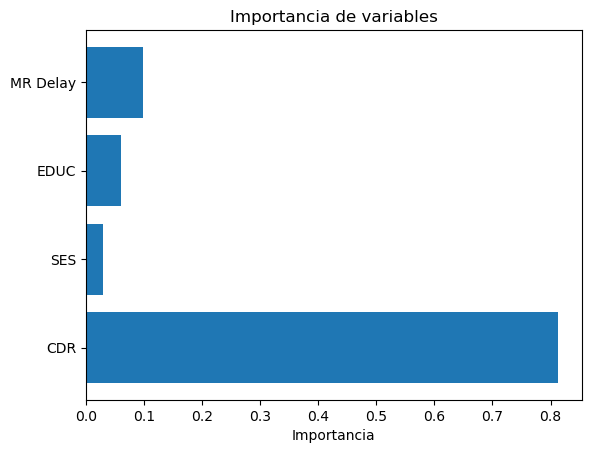

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
TAM_ENTRENAMIENTO=0.8

debug = False

#X = datos.drop(columns=["Group_Converted", "Group_Demented", "Group_Nondemented"])

X2= datos[["CDR","SES","EDUC","MR Delay"]]

semilla=42

x_train, x_test, y_train, y_test = train_test_split(X2, target, train_size = TAM_ENTRENAMIENTO, random_state = semilla,shuffle=True)

if debug:

    #probamos diferentes hiper parámetros
    params = {
        "max_depth": [3, 5, 10, 20, None],
        "max_features":['auto','sqrt','log2'],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4, 8,16],
        "criterion": ["gini", "entropy","log_lost"]
    }

    arbol=DecisionTreeClassifier(random_state=semilla)
    grid = GridSearchCV(arbol, params, cv=5)
    grid.fit(x_train, y_train)

    #conseguimos los mejores
    print(f"Mejores parámetros: {grid.best_params_}")
    y_pred_grid = grid.predict(x_test)
    #vemos el mayor fit conseguido
    print(f'Acuraccy optimizado: {accuracy_score(y_test, y_pred_grid)}')
    print(confusion_matrix(y_test, y_pred_grid))
    


print(f"tamaño de los datos de entrenamiento:{x_train.shape}")
print(f"tamaño de los datos de test:{x_test.shape}")


# Create the model
dtClass = DecisionTreeClassifier(max_depth=10,min_samples_leaf=4,min_samples_split=2,criterion='gini')
dtClassFit = dtClass.fit(x_train, y_train)
y_pred_dt = dtClassFit.predict(x_test)

print(f'Acuraccy: {accuracy_score(y_test, y_pred_dt)}')
print(confusion_matrix(y_test, y_pred_dt))
print(f'Semilla={semilla}')

#miramos las más relevantes
importancias = dtClass.feature_importances_
features = X.columns

plt.barh(features, importancias)
plt.xlabel("Importancia")
plt.title("Importancia de variables")
plt.show()


### Ejercicio 4 (1 Punto) compara los resultados de ambos y justifica con cual te quedarías

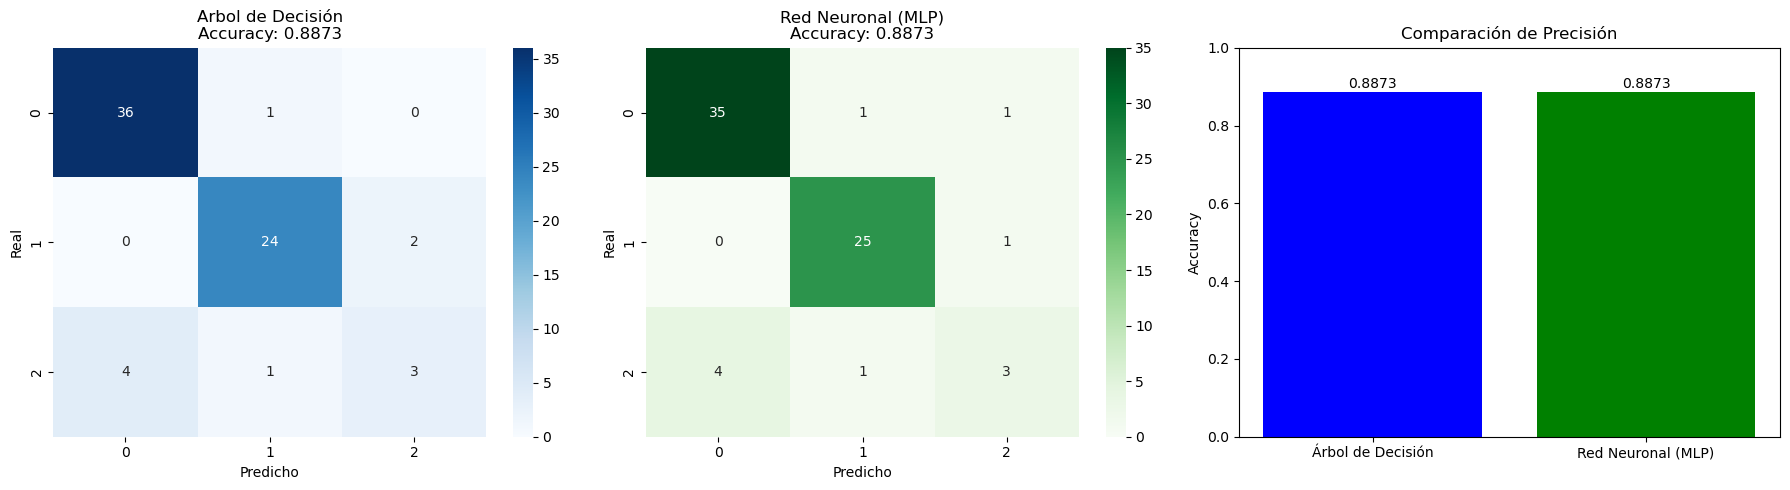

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Asumimos que ya tienes:
# y_test, y_pred_dt (del árbol de decisión), y_pred_mlp (de la red neuronal)

# Calcular matrices de confusión
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Calcular accuracies
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_mlp = accuracy_score(y_test, y_pred_mlp)

# Crear gráfico de matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Arbol de Decisión\nAccuracy: {acc_dt:.4f}')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Red Neuronal (MLP)\nAccuracy: {acc_mlp:.4f}')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

# Crear gráfico de barras con accuracy
modelos = ['Árbol de Decisión', 'Red Neuronal (MLP)']
scores = [acc_dt, acc_mlp]

axes[2].bar(modelos, scores, color=['blue', 'green'])
axes[2].set_ylim(0, 1)
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Comparación de Precisión')

for i, v in enumerate(scores):
    axes[2].text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

##Elegimos Árbol de decisiones ya que tienen misma accuracy y ademas es un modelo de CAJA BLANCA por lo que es explicable a diferencia MLP que es un modelo de CAJA NEGRA


### Elegimos Árbol de decisiones ya que tienen misma accuracy y ademas es un modelo de CAJA BLANCA por lo que es explicable a diferencia MLP que es un modelo de CAJA NEGRA
